In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.stem import PorterStemmer
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [6]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [7]:
train.isna().sum()

id           0
title      558
author    1957
text        39
label        0
dtype: int64

In [8]:
test.isna().sum()

id          0
title     122
author    503
text        7
dtype: int64

In [9]:
train = train.fillna('')
test = test.fillna('')

In [10]:
train['data'] = train['title'] + ". "+train['author']+". "+train['text']
test['data'] = test['title'] + ". "+ test['author']+ ". "+test['text']

In [12]:
#class imbalance
print(train['label'].value_counts())
fake_news_count =len(train[train['label']==1])
real_news_count = len(train[train['label']== 0])

1    10413
0    10387
Name: label, dtype: int64


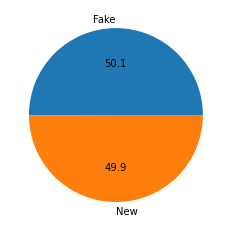

In [15]:
y = np.array([fake_news_count,real_news_count])
mylabels = ['Fake','New']
plt.pie(y,labels=mylabels,autopct='%.1f')
plt.show()


In [16]:
#there are equal representation of both classes
#checking the character lenght of fake and real
train['len_text'] = train['data'].apply(lambda x : len(x))

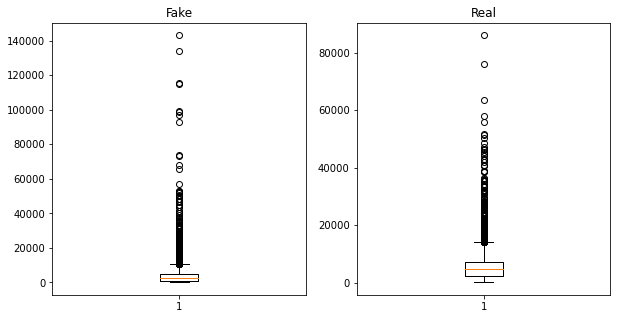

In [20]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))

ax1.boxplot(train[train['label']==1]['len_text'])
ax1.set_title('Fake')
ax2.boxplot(train[train['label']==0]['len_text'])
ax2.set_title('Real')

plt.show()

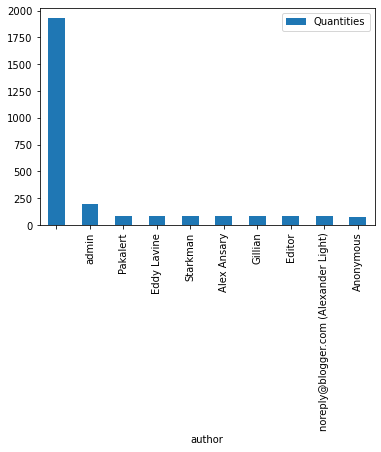

In [23]:
#fake news have less words compared to real
#now let's check the top author's for each class
#Fake New author
fake_author = pd.DataFrame({'author':train[train['label']==1]['author'].value_counts().head(10).index,'Quantities':train[train['label']==1]['author'].value_counts().head(10)})

fake_author.plot(kind='bar',x='author',y='Quantities')

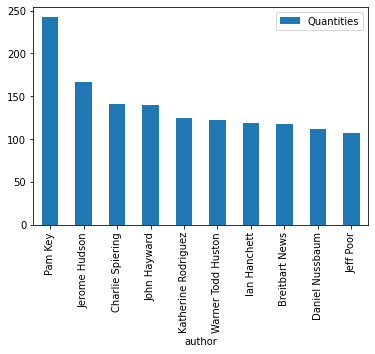

In [24]:
real_author = pd.DataFrame({'author':train[train['label']==0]['author'].value_counts().head(10).index,'Quantities':train[train['label']==0]['author'].value_counts().head(10)})

real_author.plot(kind='bar',x='author',y='Quantities')

In [25]:
#From this we can deduce that real news are usually authored , hence we will include the author name in our text data


In [30]:
#Preprocessing Data


In [31]:
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score

lm = WordNetLemmatizer()

In [32]:
# train.dropna(subset=['title'],inplace=True)
stop_words=stopwords.words('english')
def preprocess(text):
    text=str(text)
    text=text.lower()
    text.translate(str.maketrans('', '', string.punctuation))
    text=word_tokenize(text)
    text=[lm.lemmatize(word) for word in text if text not in stop_words]
    text=" ".join(text)
    return text
    

In [33]:
train['data']=train['data'].apply(preprocess)

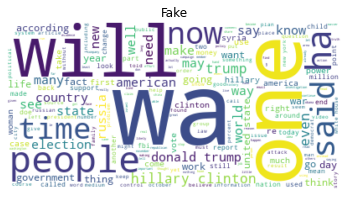

In [129]:
#checking the words that are most prominent/important in both the classes
wc = WordCloud(background_color = 'white')
wc.generate(' '.join(train[train['label']==1]['data']))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Fake')
plt.axis('off')
plt.show()

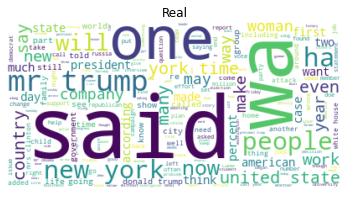

In [131]:
wc = WordCloud(background_color = 'white')
wc.generate(' '.join(train[train['label']==0]['data']))
plt.imshow(wc,interpolation = 'bilinear')
plt.title('Real')
plt.axis('off')
plt.show()

In [34]:
X=train['data']
y=train['label']

In [37]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import average_precision_score
from sklearn.linear_model import LogisticRegression

In [113]:
#Create a base model usng simplest logistic regression on both count vectorizer and tf_idf
#bow
vectorizer = CountVectorizer()
X_bow = vectorizer.fit_transform(X)


In [41]:
#tfidf

tf_idf = TfidfVectorizer(
    analyzer="word",
    preprocessor=None, stop_words='english', max_features=None)    

X_tfidf= tf_idf.fit_transform(X)

In [42]:
X_train, X_test, y_train, y_test = train_test_split( X_bow, y, test_size=0.33, random_state=42)

#creating a base model using bow vectors
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("the accuracy score for LR using Bow is :",score)

average_precision = average_precision_score(y_test, predictions)
print(average_precision)

the accuracy score for LR using Bow is : 0.9694055944055944
0.9557798832036917


C:\Users\ruhins.NETSCRIBES\.conda\envs\hdfc_env\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [43]:
X_train, X_test, y_train, y_test = train_test_split( X_tfidf, y, test_size=0.33, random_state=42)

#creating a base model using bow vectors
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("The accuracy for LR using tfidf is ,",score)

average_precision = average_precision_score(y_test, predictions)
print(average_precision)

The accuracy for LR using tfidf is , 0.9538170163170163
0.9290628834239801


In [44]:
print("According to the above baseline fit, BoW performs better, let's test on other models")

According to the above baseline fit, BoW performs better, let's test on other models


In [62]:
#DecisionTree
from sklearn.tree import DecisionTreeClassifier
#using tf-idf
X_train, X_test, y_train, y_test = train_test_split( X_tfidf, y, test_size=0.33, random_state=42)
# Make a decision tree and train
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print(f'Model Accuracy: {tree.score(X_test, y_test)}')

Model Accuracy: 0.9584790209790209


In [46]:
#using tfidf
X_train, X_test, y_train, y_test = train_test_split( X_bow, y, test_size=0.33, random_state=42)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print(f'Model Accuracy: {tree.score(X_test, y_test)}')

Model Accuracy: 0.9657634032634033


In [48]:
print("Using BoW is proving to give us slightly better results, but Logistic Regression has the highest accuracy of 0.969")

Using BoW is proving to give us slightly better results, but Logistic Regression has the highest accuracy of 0.969


In [66]:
#lets try SGD on BoW
from sklearn.linear_model import SGDClassifier
X_train, X_test, y_train, y_test = train_test_split( X_bow, y, test_size=0.33, random_state=42)
clf = SGDClassifier(penalty='l2',loss='hinge',max_iter=100)
clf.fit(X_train, y_train)
print(f'Model Accuracy: {clf.score(X_test, y_test)}')

Model Accuracy: 0.962995337995338


In [67]:
#we tune LogisticRegression to improve accuracy
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=logisticRegr, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Best: 0.968953 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.966346 (0.004310) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.967327 (0.004785) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.967231 (0.004017) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.966777 (0.004297) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.967494 (0.003872) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.967614 (0.004162) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.967231 (0.004272) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.967686 (0.003931) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.968451 (0.004022) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.966968 (0.004438) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.967686 (0.004379) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.968953 (0.004510) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.964624 (0.004642) wit

In [ ]:
##Fitting the model with new parameters
X_train, X_test, y_train, y_test = train_test_split( X_bow, y, test_size=0.33, random_state=42)

#creating a base model using bow vectors
logisticRegr = LogisticRegression(C=0.1,penalty='l2',solver='liblinear')
logisticRegr.fit(X_train, y_train)

In [133]:
predictions = logisticRegr.predict(X_test)
score = logisticRegr.score(X_test, y_test)
print("The accuracy for LR using tfidf is ,",score)

average_precision = average_precision_score(y_test, predictions)
print(average_precision)

The accuracy for LR using tfidf is , 0.9723193473193473
0.9596284584561879


In [148]:
cm = metrics.confusion_matrix(y_test, predictions,labels=[0,1])
print(cm)
precison_for_class_0=(3359/(3359+90))
print(precison_for_class_0)
precision_for_class_1=(3315/(3315+100))
print(precision_for_class_1)


[[3359   90]
 [ 100 3315]]
0.9739054798492317
0.9707174231332357


In [73]:
print("We observe that we have slightly better accuracy than the previous model that we fit")

We observe that we have slightly better accuracy than the previous model that we fit


In [74]:
#Just to check if we can get a better accuracy using LSTM
from tensorflow.keras.layers import Embedding,LSTM,Dense,Dropout,SpatialDropout1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping

In [76]:

X_lstm=train['data']
y_lstm=Y = pd.get_dummies(train['label']).values


In [77]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(X_lstm.values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 182026 unique tokens.


In [78]:
X_l= tokenizer.texts_to_sequences(X_lstm.values)
X_l= pad_sequences(X_l, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X_l.shape)

Shape of data tensor: (20800, 250)


In [79]:
Xl_train, Xl_test, yl_train, yl_test = train_test_split( X_l, y_lstm, test_size=0.33, random_state=42)
print('Shape of data tensor:', Xl_train.shape,yl_train.shape)

Shape of data tensor: (13936, 250) (13936, 2)


In [81]:
lstm = Sequential()
lstm.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X_l.shape[1]))
lstm.add(SpatialDropout1D(0.2))
lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(2, activation='softmax'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 6
batch_size = 64

history = lstm.fit(Xl_train, yl_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,
                   callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Train on 12542 samples, validate on 1394 samples
Epoch 1/6
12542/12542 [==============================] - 272s 22ms/sample - loss: 0.3592 - accuracy: 0.8388 - val_loss: 0.1962 - val_accuracy: 0.9211
Epoch 2/6
12542/12542 [==============================] - 289s 23ms/sample - loss: 0.1457 - accuracy: 0.9499 - val_loss: 0.1909 - val_accuracy: 0.9283
Epoch 3/6
12542/12542 [==============================] - 292s 23ms/sample - loss: 0.0974 - accuracy: 0.9687 - val_loss: 0.1913 - val_accuracy: 0.9311
Epoch 4/6
12542/12542 [==============================] - 292s 23ms/sample - loss: 0.0744 - accuracy: 0.9731 - val_loss: 0.1836 - val_accuracy: 0.9390
Epoch 5/6
12542/12542 [==============================] - 309s 25ms/sample - loss: 0.0355 - accuracy: 0.9886 - val_loss: 0.2559 - val_accuracy: 0.9218
Epoch 6/6
12542/12542 [==============================] - 405s 32ms/sample - loss: 0.0265 - accuracy: 0.9935 - val_loss: 1.4336 - val_accuracy: 0.8020


In [82]:
accr = lstm.evaluate(Xl_test,yl_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

6864/6864 [==============================] - 37s 5ms/sample - loss: 1.5099 - accuracy: 0.7937
Test set
  Loss: 1.510
  Accuracy: 0.794


In [95]:
test['data']=test['data'].apply(preprocess)

In [114]:
test_x= vectorizer.transform(test['data'].values)

In [115]:
print(X_bow.shape)

(20800, 172633)


In [116]:
print(test_x.shape)

(5200, 172633)


In [117]:
#The model accuracy for LSTM was low compared to Logistic Regression, so we will create the new dataset on the entire data
#creating finak model using bow vectors
logisticRegrfinal = LogisticRegression(C=0.1,penalty='l2',solver='liblinear')
logisticRegrfinal.fit(X_bow, y)

LogisticRegression(C=0.1, solver='liblinear')

In [118]:
predictions=logisticRegrfinal.predict(test_x)
# score = logisticRegrfinal.score(X_test, y_test)
# print("The accuracy for LR using tfidf is ,",score)

# average_precision = average_precision_score(y_test, predictions)
# print(average_precision)

0.9596284584561879


In [120]:
test['label']=predictions

In [121]:
test

,id,title,author,text,data,label
0,20800,"Specter of Trump Loosens Tongues, if Not Purse...",David Streitfeld,"PALO ALTO, Calif. — After years of scorning...","specter of trump loosens tongue , if not purse...",0
1,20801,Russian warships ready to strike terrorists ne...,,Russian warships ready to strike terrorists ne...,russian warship ready to strike terrorist near...,1
2,20802,#NoDAPL: Native American Leaders Vow to Stay A...,Common Dreams,Videos #NoDAPL: Native American Leaders Vow to...,# nodapl : native american leader vow to stay ...,1
3,20803,"Tim Tebow Will Attempt Another Comeback, This ...",Daniel Victor,"If at first you don’t succeed, try a different...","tim tebow will attempt another comeback , this...",0
4,20804,Keiser Report: Meme Wars (E995),Truth Broadcast Network,42 mins ago 1 Views 0 Comments 0 Likes 'For th...,keiser report : meme war ( e995 ) . truth broa...,1
...,...,...,...,...,...,...
5195,25995,The Bangladeshi Traffic Jam That Never Ends - ...,Jody Rosen,Of all the dysfunctions that plague the world’...,the bangladeshi traffic jam that never end - t...,0
5196,25996,John Kasich Signs One Abortion Bill in Ohio bu...,Sheryl Gay Stolberg,WASHINGTON — Gov. John Kasich of Ohio on Tu...,john kasich sign one abortion bill in ohio but...,0
5197,25997,"California Today: What, Exactly, Is in Your Su...",Mike McPhate,Good morning. (Want to get California Today by...,"california today : what , exactly , is in your...",0
5198,25998,300 US Marines To Be Deployed To Russian Borde...,,« Previous - Next » 300 US Marines To Be Deplo...,300 u marine to be deployed to russian border ...,1


In [125]:
submit_data=test[["id","label"]]

In [127]:
submit_data.to_csv('submit_01.csv')